In [72]:
from tqdm import trange
from algs_one_mtx import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from models.dbsl import DBSL

from env_cifar import *

In [73]:
images, labels = load_cifar10("datasets/CIFAR10")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)
print(features.shape)
print([len(clusters[k]) for k in range(10)])

(50000, 3072)
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


In [74]:
betas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 1, 2, 20, 200, 2000, 20000]
ranks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300,400, 500]
ms = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300,400, 500]
target_classes = [0, 2,4, 5, 8]

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time
from itertools import product

T_cv = 1000
T = 4000
n_runs = 1


def run_cv(dataset='mnist'):
    if dataset == 'mnist':
        d = 784
        EnvClass = MNISTBanditEnv
    else:
        d = 3072
        EnvClass = CIFAR10BanditEnv

    num_arms = 10

    print(f"=== {dataset.upper()} Cross-Validation ===")

    best_params = {
        'LinUCB': {},
        'PSI-LinUCB': {},
        'CBSCFD': {}
    }

    # Лучшие параметры для каждого rank/m
    best_per_rank = {}
    best_per_m = {}

    for tc in target_classes:
        print(f"\n{'='*50}")
        print(f"Target class {tc}")
        print(f"{'='*50}")

        # LinUCB
        best_lin = {'score': float('inf')}
        for alpha, eps in product(betas, lambdas):
            np.random.seed(0)
            bandit = LinUCB_SM(d, alpha, eps)
            env = EnvClass(clusters, target_class=tc)
            for t in range(T_cv):
                ctx = env.get_contexts()
                action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
                reward = env.step(action)
                bandit.update(ctx[action], reward)
            if env.mistakes < best_lin['score']:
                best_lin = {'score': env.mistakes, 'alpha': alpha, 'epsilon': eps}
        best_params['LinUCB'][tc] = best_lin
        print(f"\nLinUCB best: {best_lin}")

        # PSI-LinUCB — лучшие параметры для каждого rank
        print(f"\nPSI-LinUCB by rank:")
        best_per_rank[tc] = {}
        best_psi = {'score': float('inf')}

        for rank in ranks:
            best_for_rank = {'score': float('inf')}
            for alpha, eps in product(betas, lambdas):
                np.random.seed(0)
                bandit = LinUCBwithPSI_rank1(d, eps, alpha, rank)
                env = EnvClass(clusters, target_class=tc)
                for t in range(T_cv):
                    ctx = env.get_contexts()
                    action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
                    reward = env.step(action)
                    bandit.update(ctx[action], reward)
                if env.mistakes < best_for_rank['score']:
                    best_for_rank = {'score': env.mistakes, 'alpha': alpha, 'epsilon': eps, 'rank': rank}

            best_per_rank[tc][rank] = best_for_rank
            print(f"  rank={rank:3d}: mistakes={best_for_rank['score']:4d}, alpha={best_for_rank['alpha']}, eps={best_for_rank['epsilon']}")

            if best_for_rank['score'] < best_psi['score']:
                best_psi = best_for_rank

        best_params['PSI-LinUCB'][tc] = best_psi
        print(f"  BEST: {best_psi}")

        # CBSCFD — лучшие параметры для каждого m
        print(f"\nCBSCFD by m:")
        best_per_m[tc] = {}
        best_cbscfd = {'score': float('inf')}

        for m in ms:
            best_for_m = {'score': float('inf')}
            for beta, lambd in product(betas, lambdas):
                np.random.seed(0)
                bandit = CBSCFD(lambd, beta, m, d)
                env = EnvClass(clusters, target_class=tc)
                for t in range(T_cv):
                    ctx = env.get_contexts()
                    action = bandit.select_arm(ctx)
                    reward = env.step(action)
                    bandit.update(ctx[action], reward)
                if env.mistakes < best_for_m['score']:
                    best_for_m = {'score': env.mistakes, 'beta': beta, 'lambd': lambd, 'm': m}

            best_per_m[tc][m] = best_for_m
            print(f"  m={m:3d}: mistakes={best_for_m['score']:4d}, beta={best_for_m['beta']}, lambd={best_for_m['lambd']}")

            if best_for_m['score'] < best_cbscfd['score']:
                best_cbscfd = best_for_m

        best_params['CBSCFD'][tc] = best_cbscfd
        print(f"  BEST: {best_cbscfd}")

    # === Финальный эксперимент ===
    print(f"\n{'='*50}")
    print(f"{dataset.upper()} Final Experiment")
    print(f"{'='*50}")

    results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD']}
    times = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD']}

    for run in range(n_runs):
        for tc in target_classes:
            np.random.seed(run * 10 + tc)

            p_lin = best_params['LinUCB'][tc]
            p_psi = best_params['PSI-LinUCB'][tc]
            p_cbscfd = best_params['CBSCFD'][tc]

            linucb = LinUCB_SM(d, p_lin['alpha'], p_lin['epsilon'])
            psi = LinUCBwithPSI_rank1(d, p_psi['epsilon'], p_psi['alpha'], p_psi['rank'])
            cbscfd = CBSCFD(p_cbscfd['lambd'], p_cbscfd['beta'], p_cbscfd['m'], d)

            env_lin = EnvClass(clusters, target_class=tc)
            env_psi = EnvClass(clusters, target_class=tc)
            env_cbscfd = EnvClass(clusters, target_class=tc)

            t_lin, t_psi, t_cbscfd = 0, 0, 0

            for t in range(T):
                np.random.seed(run * T * 10 + tc * T + t)
                ctx = env_lin.get_contexts()

                t0 = time.perf_counter()
                action = int(np.argmax([linucb.score(ctx[a]) for a in range(num_arms)]))
                reward = env_lin.step(action)
                linucb.update(ctx[action], reward)
                t_lin += time.perf_counter() - t0

                t0 = time.perf_counter()
                action = int(np.argmax([psi.score(ctx[a]) for a in range(num_arms)]))
                reward = env_psi.step(action)
                psi.update(ctx[action], reward)
                t_psi += time.perf_counter() - t0

                t0 = time.perf_counter()
                action = cbscfd.select_arm(ctx)
                reward = env_cbscfd.step(action)
                cbscfd.update(ctx[action], reward)
                t_cbscfd += time.perf_counter() - t0

            results['LinUCB'].append(env_lin.cumulative_mistakes)
            results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
            results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)

            times['LinUCB'].append(t_lin)
            times['PSI-LinUCB'].append(t_psi)
            times['CBSCFD'].append(t_cbscfd)

    # === Графики ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red'}

    ax = axes[0]
    for name in results:
        arr = np.array(results[name])
        mean = np.mean(arr, axis=0)
        std = np.std(arr, axis=0)
        ax.plot(mean, label=name, color=colors[name])
        ax.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Mistakes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{dataset.upper()} Online Mistakes')

    ax = axes[1]
    names = list(times.keys())
    mean_times = [np.mean(times[n]) for n in names]
    bars = ax.bar(names, mean_times, color=[colors[n] for n in names])
    ax.set_ylabel('Time (s)')
    ax.set_title('Running Time')
    ax.grid(True, alpha=0.3, axis='y')
    for bar, t in zip(bars, mean_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{t:.1f}', ha='center')

    plt.tight_layout()
    plt.savefig(f'{dataset}_results.png', dpi=150)
    plt.show()

    print(f"\nFinal ({dataset.upper()}):")
    for name in results:
        arr = np.array(results[name])
        print(f"{name}: {np.mean(arr[:,-1]):.1f}±{np.std(arr[:,-1]):.1f}, Time={np.mean(times[name]):.1f}s")

    return best_params, best_per_rank, best_per_m


# Запуск:
# params, per_rank, per_m = run_cv('mnist')
# params, per_rank, per_m = run_cv('cifar')

=== CIFAR Cross-Validation ===

Target class 0

LinUCB best: {'score': 571, 'alpha': 0.0001, 'epsilon': 0.2}

PSI-LinUCB by rank:
  rank= 10: mistakes= 583, alpha=0.0001, eps=1
  rank= 20: mistakes= 577, alpha=0.1, eps=1
  rank= 30: mistakes= 575, alpha=0.1, eps=1
  rank= 40: mistakes= 576, alpha=0.1, eps=1
  rank= 50: mistakes= 576, alpha=0.1, eps=1
  rank= 60: mistakes= 576, alpha=0.1, eps=1
  rank= 70: mistakes= 571, alpha=0.0001, eps=0.2
  rank= 80: mistakes= 571, alpha=0.001, eps=0.2
  rank= 90: mistakes= 561, alpha=0.001, eps=0.2
  rank=100: mistakes= 572, alpha=0.001, eps=0.2
  rank=200: mistakes= 564, alpha=0.001, eps=0.2
  rank=300: mistakes= 566, alpha=0.001, eps=0.2
  rank=400: mistakes= 565, alpha=0.001, eps=0.2
  rank=500: mistakes= 566, alpha=0.001, eps=0.2
  BEST: {'score': 561, 'alpha': 0.001, 'epsilon': 0.2, 'rank': 90}

CBSCFD by m:
  m= 10: mistakes= 573, beta=0.01, lambd=0.2
  m= 20: mistakes= 571, beta=0.0001, lambd=0.2
  m= 30: mistakes= 571, beta=0.0001, lambd=0.

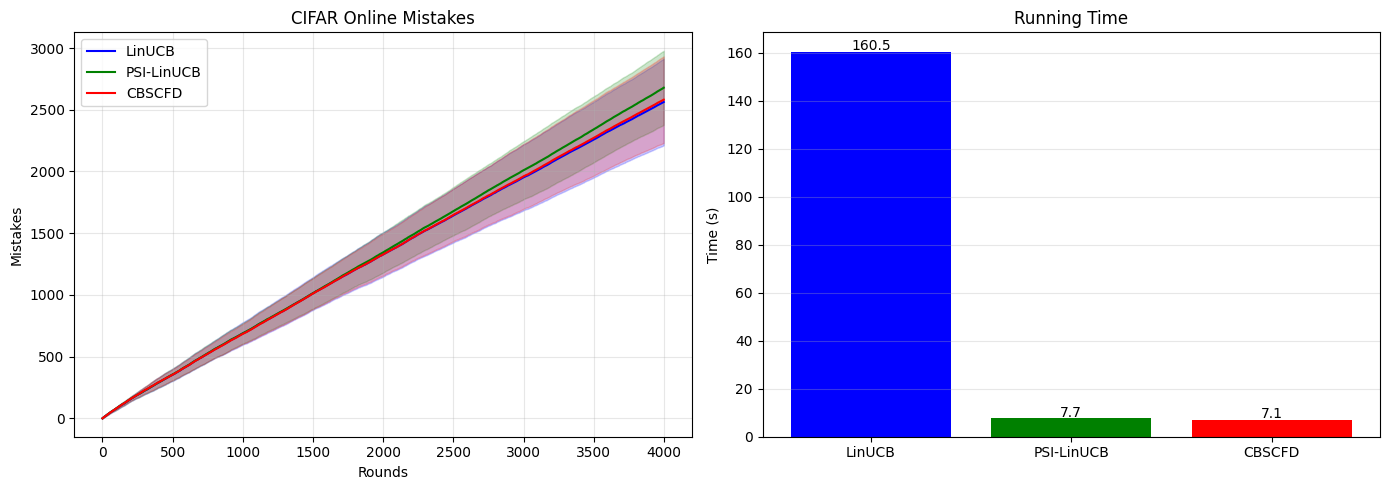


Final (CIFAR):
LinUCB: 2562.8±351.3, Time=160.5s
PSI-LinUCB: 2678.4±299.6, Time=7.7s
CBSCFD: 2581.4±350.8, Time=7.1s


In [77]:
params, per_rank, per_m = run_cv('cifar')

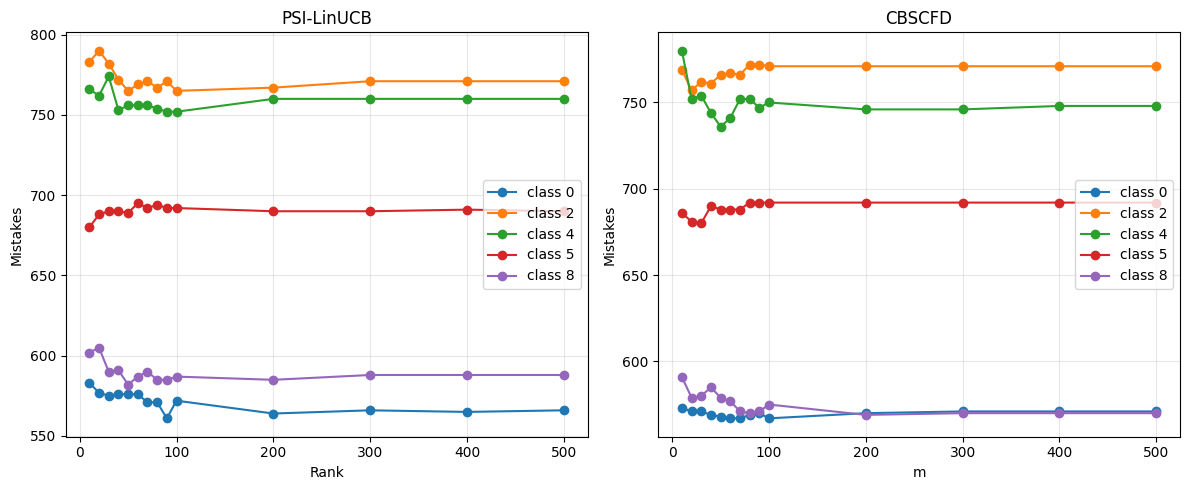

In [78]:
# Графики зависимости ошибок от rank/m для каждого класса
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PSI-LinUCB: ошибки от rank
ax = axes[0]
for tc in target_classes:
    ranks_list = sorted(per_rank[tc].keys())
    mistakes = [per_rank[tc][r]['score'] for r in ranks_list]
    ax.plot(ranks_list, mistakes, marker='o', label=f'class {tc}')
ax.set_xlabel('Rank')
ax.set_ylabel('Mistakes')
ax.set_title('PSI-LinUCB')
ax.legend()
ax.grid(True, alpha=0.3)

# CBSCFD: ошибки от m
ax = axes[1]
for tc in target_classes:
    ms_list = sorted(per_m[tc].keys())
    mistakes = [per_m[tc][m]['score'] for m in ms_list]
    ax.plot(ms_list, mistakes, marker='o', label=f'class {tc}')
ax.set_xlabel('m')
ax.set_ylabel('Mistakes')
ax.set_title('CBSCFD')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
import pandas as pd

# PSI-LinUCB results
psi_data = []
for tc in target_classes:
    for rank in per_rank[tc]:
        p = per_rank[tc][rank]
        psi_data.append({
            'class': tc,
            'rank': rank,
            'mistakes': p['score'],
            'alpha': p['alpha'],
            'epsilon': p['epsilon']
        })
df_psi = pd.DataFrame(psi_data)
df_psi.to_csv('psi_results_cif.csv', index=False)

# CBSCFD results
cbscfd_data = []
for tc in target_classes:
    for m in per_m[tc]:
        p = per_m[tc][m]
        cbscfd_data.append({
            'class': tc,
            'm': m,
            'mistakes': p['score'],
            'beta': p['beta'],
            'lambd': p['lambd']
        })
df_cbscfd = pd.DataFrame(cbscfd_data)
df_cbscfd.to_csv('cbscfd_results_cif.csv', index=False)

print("Saved: psi_results.csv, cbscfd_results.csv")

Saved: psi_results.csv, cbscfd_results.csv


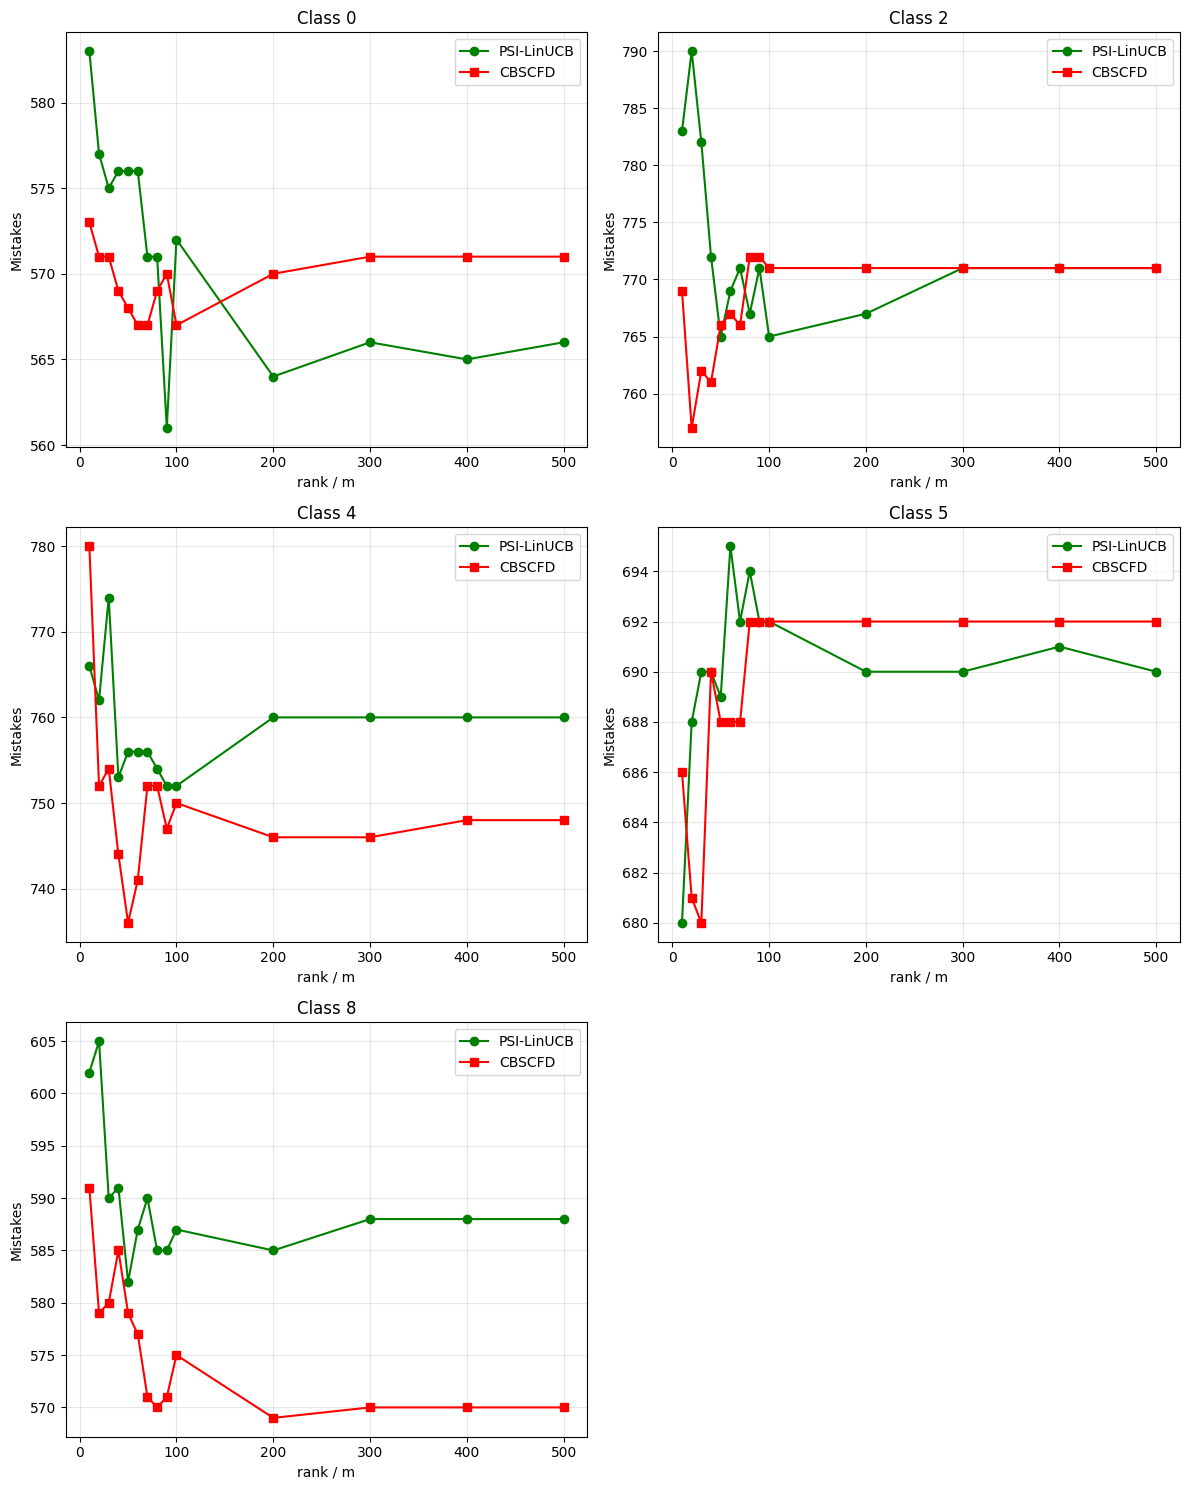

In [81]:
n_classes = len(target_classes)
n_cols = 2
n_rows = (n_classes + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()  # превращаем в 1D массив

for i, tc in enumerate(target_classes):
    ax = axes[i]

    # PSI-LinUCB
    ranks_list = sorted(per_rank[tc].keys())
    mistakes_psi = [per_rank[tc][r]['score'] for r in ranks_list]
    ax.plot(ranks_list, mistakes_psi, marker='o', label='PSI-LinUCB', color='green')

    # CBSCFD
    ms_list = sorted(per_m[tc].keys())
    mistakes_cbscfd = [per_m[tc][m]['score'] for m in ms_list]
    ax.plot(ms_list, mistakes_cbscfd, marker='s', label='CBSCFD', color='red')

    ax.set_xlabel('rank / m')
    ax.set_ylabel('Mistakes')
    ax.set_title(f'Class {tc}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Убираем лишние subplot'ы если есть
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()